# Прогнозирование температуры звезды

**Источник данных:** данные предоставлены заказчиком.

**Характер данных:** характеристики изученных 240 звёзд.

**Цель заказчика:** внедрение технологии машинного обучения для предсказания температуры звёзд.

**Задача исследования:** разработка нейронной сети, предсказывающей абсолютную температуру на поверхности звезды.

**Заказчику важны:** качество предсказания.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Загрузка данных

Импорт необходимых библиотек:

In [1]:
import numpy as np
import pandas as pd

import itertools
from typing import Tuple
from tqdm.notebook import tqdm

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

Задание случайных величин:

In [2]:
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

RANDOM_STATE = 42

Загрузка исходного набора данных:

In [3]:
data = pd.read_csv('/datasets/6_class.csv').iloc[:, 1:]

Выведение на экран первых пяти строк набора данных:

In [4]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


Выведение на экран размера исходных данных:

In [5]:
print('Размер набора данных:', data.shape)

Размер набора данных: (240, 6)


<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
Предоставленные данные соответствуют заявленному описанию и поставленной задаче.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Общий анализ данных

Задание функции, выводящей на экран графики распределения значений в переданном столбце:

In [6]:
def plot_box_hist(col_name: str, df: pd.DataFrame):
    font_s = 12

    fig, (ax_box, ax_hist) = plt.subplots(2, 
                                          sharex=True, 
                                          gridspec_kw={"height_ratios": (.25, .75)},
                                          figsize=(6,5))

    plt.suptitle(f'Столбец {col_name}\n', fontsize=font_s+4)
    
    ax_box.boxplot(df[col_name], vert=False)
    ax_hist.hist(df[col_name])

    ax_box.grid()
    ax_hist.grid()

    plt.xlabel(col_name, fontsize=font_s)
    plt.ylabel('frequency', fontsize=font_s)

    plt.show()

---

Выведение на экран общей информации об исходном наборе данных:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Категориальные столбцы `Star type` и `Star color` можно привести к типу данных `category` для сокращения объёма занимаемой набором данных памяти.
    
</div>

Выведение на экран названий столбцов исходного набора данных:

In [8]:
data.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Оформление названий столбцов необходимо привести к удобному для работы с набором данных формату.
    
</div>

Выведение на экран числовых характеристик исходного набора данных:

In [9]:
data.drop('Star type', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* В столбце `Absolute magnitude(Mv)` допускаются отрицательные значения ([Wikipedia](https://en.wikipedia.org/wiki/Absolute_magnitude)).
    
</div>

Выведение на экран количества пропущенных значений в исходном наборе данных:

In [10]:
data.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

Выведение на экран общего числа дубликатов в исходном наборе данных:

In [11]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


Выведение на экран распределения значений в категориальных столбцах:

In [12]:
for col_name in data[['Star type', 'Star color']]:
    print('Столбец:', col_name)
    print(data[col_name].value_counts())
    print('\n---\n')

Столбец: Star type
0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64

---

Столбец: Star color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Yellowish White         3
Blue white              3
Orange                  2
yellowish               2
Whitish                 2
White-Yellow            1
Blue white              1
Orange-Red              1
Yellowish               1
Blue                    1
Blue-White              1
Pale yellow orange      1
Name: Star color, dtype: int64

---



<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* В столбце `Star color` обнаружены неявные дубликаты значений. 
    
</div>

Выведение на экран количества строк в наборе данных, значения которых превышают светимость Солнца:

In [13]:
l_sun = 3.828 * 10 ** 26

print('Значений, превышающих светимость Солнца:', 
      data[data['Luminosity(L/Lo)'] >= l_sun]['Luminosity(L/Lo)'].count())

Значений, превышающих светимость Солнца: 0


Выведение на экран количества строк в наборе данных, значения которых превышают радиус Солнца:

In [14]:
r_sun = 6.9551 * 10 ** 8

print('Значений, превышающих радиус Солнца:', 
      data[data['Radius(R/Ro)'] >= r_sun]['Radius(R/Ro)'].count())

Значений, превышающих радиус Солнца: 0


Выведение на экран графика распределений в числовых столбцах исходного набора данных:

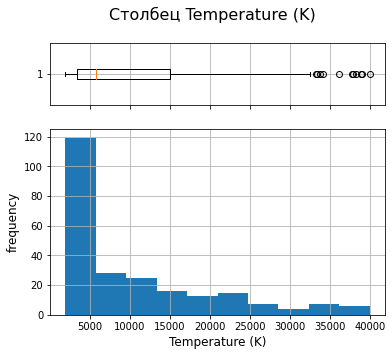

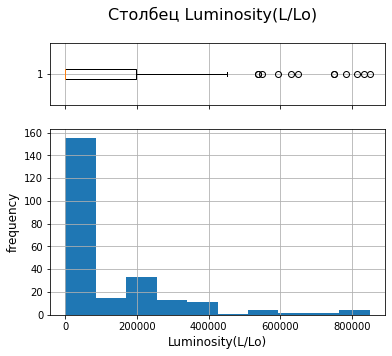

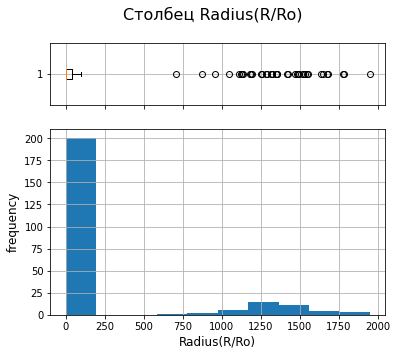

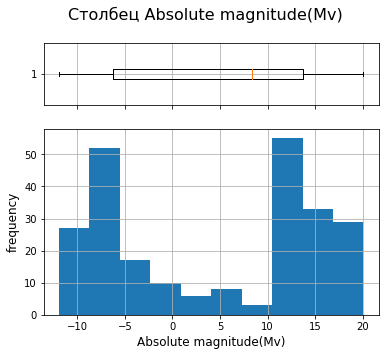

In [15]:
for column in data.columns[:-2]:
    plot_box_hist(column, data)

Выведение на экран матрицы рассеяния числовых значений:

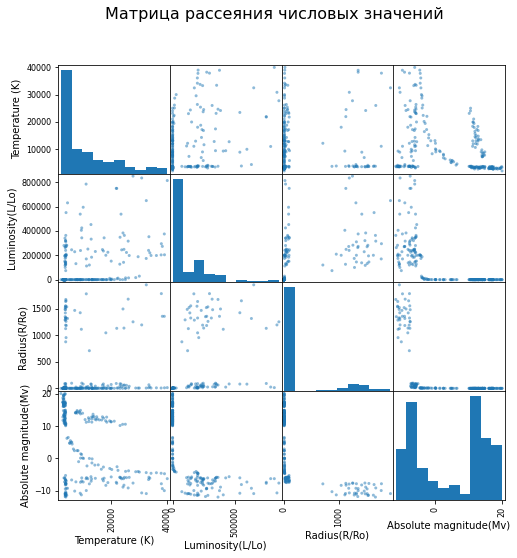

In [16]:
pd.plotting.scatter_matrix(data.drop(['Star type', 'Star color'], axis=1), figsize=(8,8))

plt.suptitle('Матрица рассеяния числовых значений', fontsize=16)

plt.show()

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Явных линейных зависимостей в данных не обнаружено.
    
</div>

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
В ходе предварительного анализа были обнаружены ошибки в формате значений набора данных, которые необходимо исправить для обеспечения корректности построения модели нейронной сети.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Предобработка данных

### Названия столбцов

Переименовывание столбцов:

In [17]:
data.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'type', 'color']

Выведение на экран названий столбцов для проверки применённых изменений:

In [18]:
data.columns

Index(['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'type',
       'color'],
      dtype='object')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Названия столбцов были приведены к удобному для работы с набором данных виду.
    
</div>

---

### Неявные дубликаты

Выведение на экран уникальных значений столбца `color`:

In [19]:
data['color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Приведение значений столбца `color` к нижнему регистру и удаление лишних пробелов:

In [20]:
data['color'] = data['color'].str.lower()
data['color'] = data['color'].apply(lambda x: x.strip().replace('-', ' '))

Выведение на экран уникальных значений столбца `color` для проверки применённых изменений:

In [21]:
data['color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

С учётом вариаций цветов "беловатый" и "желтоватый" наравне с "белый" и "жёлтый" замена значений на единый вариант не допускается.

Выведение на экран распределения значений в столбце `color`:

In [22]:
data['color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish               3
yellowish white         3
orange                  2
whitish                 2
pale yellow orange      1
orange red              1
white yellow            1
Name: color, dtype: int64

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Значения столбца `color` были очищены от неявных дубликатов.
    
</div>

---

### Типы данных

Исправление типов данных категориальных столбцов:

In [23]:
for col_name in ['type', 'color']:
    data[col_name] = data[col_name].astype('category')

Выведение на экран общей информации об исходном наборе данных для проверки применённых изменений:

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   temperature         240 non-null    int64   
 1   luminosity          240 non-null    float64 
 2   radius              240 non-null    float64 
 3   absolute_magnitude  240 non-null    float64 
 4   type                240 non-null    category
 5   color               240 non-null    category
dtypes: category(2), float64(3), int64(1)
memory usage: 8.7 KB


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Данные в столбцах были приведены к соответствующему им типу и понижены в разрядах для сокращения объёма занимаемой исходным набором данных памяти.
    
</div>

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
Исходные данные были подготовлены для построения нейронной модели.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Подготовка данных

### Разделение на выборки

Разделение набора данных на признаки объектов и целевой признак:

In [25]:
features = data.drop('temperature', axis=1)
target = data['temperature']

Сохранение названий столбцов с числовыми и категориальными признаками:

In [26]:
num_cols = features.select_dtypes(['float64', 'int64']).columns
cat_cols = features.select_dtypes(['category']).columns

Выведение на экран названий столбцов с числовыми и категориальными признаками:

In [27]:
print('Столбцы с числовыми признаками:', *num_cols)
print('Столбцы с категориальными признаками:', *cat_cols)

Столбцы с числовыми признаками: luminosity radius absolute_magnitude
Столбцы с категориальными признаками: type color


Разделение выборок на тренировочную и тестовую выборки:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

Выведение на экран размеров тренировочной и тестовой выборок:

In [29]:
print(f'Размер тренировочной выборки:', X_train.shape)
print(f'Размер тестовой выборки:', X_test.shape)

Размер тренировочной выборки: (180, 5)
Размер тестовой выборки: (60, 5)


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Данные были разделены на тернировочную и тестовую выборки.
    
</div>

---

### Кодирование данных

Задание функции определения значений категориальных признаков, различных для тестовой и тренировочной выборок:

In [30]:
def print_train_test_cat_difference(cat_cols: list, 
                                    X_train: np.array, 
                                    X_test: np.array):
    
    for col_name in cat_cols:
        cat_train = set(X_train[col_name].unique())
        cat_test = set(X_test[col_name].unique())

        if (len(cat_train) != len(cat_test) or cat_train != cat_test):
            print(f'Признак {col_name.upper()}\n')
            print('Разные значения признака в тренировочной и тестовой выборках')

            if cat_train - cat_test != set():
                print('Значения только в тренировочной выборке:\n',
                      cat_train - cat_test, '\n')

            if cat_test - cat_train != set():
                print('Значения только в тестовой выборке:\n',
                      cat_test - cat_train, '\n')

            print('---\n')

Выведение на экран значений категориальных признаков, различных для тестовой и тренировочной выборок:

In [31]:
print_train_test_cat_difference(cat_cols, X_train, X_test)

Признак COLOR

Разные значения признака в тренировочной и тестовой выборках
Значения только в тренировочной выборке:
 {'white yellow', 'pale yellow orange', 'whitish'} 

Значения только в тестовой выборке:
 {'orange red'} 

---



<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* В тренировочной и тестовой выборках в столбцах признаков нет полного соответствия значений - кодирование данных необходимо произвести с помощью техники One-Hot Encoding. 
    

* Значения в столбце `luminosity` отличаются большим диапазоном - данные необходимо масштабировать.
    

* Кодирование и масштабирование значений тестовой выборки должны происходить на объектах кодирования и масштабирования, обученных на тренировочной выборке.
    
</div>

Сохранение копий тренировочной и тестовой выборок:

In [32]:
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

Задание объекта кодирования:

In [33]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

Обучение кодировщика:

In [34]:
encoder.fit(X_train_ohe[cat_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

Добавление столбцов с закодированными данными:

In [35]:
X_train_ohe[encoder.get_feature_names()] = encoder.transform(X_train_ohe[cat_cols])
X_test_ohe[encoder.get_feature_names()] = encoder.transform(X_test_ohe[cat_cols])

Удаление исходных незакодированных столбцов:

In [36]:
X_train_ohe = X_train_ohe.drop(cat_cols, axis=1)
X_test_ohe = X_test_ohe.drop(cat_cols, axis=1)

Задание объекта масштабирования:

In [37]:
scaler = StandardScaler()

Масштабирование столбцов с числовыми значениями:

In [38]:
X_train_ohe[num_cols] = scaler.fit_transform(X_train_ohe[num_cols])
X_test_ohe[num_cols] = scaler.fit_transform(X_test_ohe[num_cols])

Выведение на экран первых пяти строк тренировочной выборки для проверки применённых изменений:

In [39]:
X_train_ohe.head()

,luminosity,radius,absolute_magnitude,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x1_blue,x1_blue white,x1_orange,x1_pale yellow orange,x1_red,x1_white,x1_white yellow,x1_whitish,x1_yellow white,x1_yellowish,x1_yellowish white
95,-0.590699,-0.427420,-0.651610,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,-0.594615,-0.441198,1.183989,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
120,-0.594615,-0.441202,1.210786,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
67,-0.594615,-0.441203,1.142836,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
101,4.142061,-0.413374,-1.027726,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Преобразование признаков объектов и целевых признаков тренировочной и тестовой выборок в тензоры:

In [40]:
X_train_ohe = torch.FloatTensor(X_train_ohe.values)
X_test_ohe = torch.FloatTensor(X_test_ohe.values)

y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Данные были закодированы и масштабированы, а также переведены в тензоры.
    
</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Построение нейронной сети

Целевой признак исследования содержит числовой диапазон значений, следовательно исследование сводится к построению модели, решающей задачу регрессии.

---

**Функции активации** - добавляют нелинейность в нейросеть.

* `nn.Sigmoid()` - логистическая функция активации.

>Применяется в моделях, предсказывающих вероятность от `0` до `1` на выходе.
>
>Может приводить к "взрыву градиентов" (слишком большим градиентам).

$$ Sigmoid(x) = \frac {1}{1 + e^{-x}} $$

* `nn.Tanh()` - гиперболический тангенс

$$ Tanh(x) = \frac {e^x - e ^{-x}}{e^x + e^{-x}} $$

>Используется в скрытых слоях при небольшом их количестве.

* `nn.ReLU()` - параметрическая выпрямительная функция.

$$ ReLU(x) = max(0, x) $$

>При отрицательных значениях признаков принимает значение `0`, что может снижать качество обучения.

* `nn.LeakyReLU()` - частный случай `nn.ReLu()`.

$$ LeakyReLU(x) = max(0.1 x, x) $$

* `nn.ELU()` - экспоненциальная линейная функция (разновидность `nn.ReLu()`).

$$ ELU(x) = \begin{cases}
k (e^x - 1),&x<0 \\
x,&x>=0
\end{cases} $$

* `nn.SiLU()` - саморегулируемая функция активации.

$$ SiLU(x) = x Sigmoid(x) = \frac {x}{1 + e^{-x}} $$

---

**Функции потерь** - помогают найти наилучшее значение параметров на тренировочных данных.

Функции потерь для **одного** объекта:

* `nn.MSELoss` - среднеквадратичное отклонение.

$$ MSE(y, \hat y) = (y - \hat y)^2 $$

* `nn.L1Loss` - среднее абсолютное отклонение.

$$ MAE(y, \hat y) = |y - \hat y| $$

Вычисление функции потерь для **набора данных**:

* Подсчёт среднего арифметического функции потерь для всех объектов набора данных.
* Вычисление суммы значений функции потерь для всех наборов данных.

---

**Оптимизатор** - содержит параметры, которые необходимо оптимизировать, реализацию алгоритма численной минимизации и необходимые гиперпараметры алгоритма.

* `optim.SGD` - метод стохастического градиентного спуска.

>Качество обучения зависит от величины шага.

$$ w_i = w_i - \eta \nabla L_i  $$

* `optim.RMSprop` - метод корневого среднеквадратического распространения (улучшение `optim.SGD()`).

$$ v_i = \gamma v_{i-1} + (1 - \gamma) (\nabla L_i)^2 $$

$$ w_i = w_{i-1} - \frac {\eta}{\sqrt {v_i}} \nabla L_i $$

* `optim.Adam` - метод адаптивной оценки моментов (улучшение `optim.SGD()`).

>Обладает быстрой сходимостью к локальному минимуму.

$$ m_i = \beta_1 m_{i-1} + (1 - \beta_1) \nabla L_i $$
$$ v_i = \beta_2 v_{i-1} + (1 - \beta_2) (\nabla L)^2 $$
$$ \hat m_i = \frac {m_i}{1 - \beta_1^i} $$
$$ \hat v_i = \frac {v_i}{1 - \beta_2^i} $$
$$ w_i = w_{i-1} - \frac {\alpha \hat m_i}{\sqrt {\hat v_i} + \epsilon} $$

* $ \nabla L $ - градиент функции потерь
* $ \eta $ - скорость обучения
* $ \gamma $ - параметр забывания
* $ \alpha = 0.0001 $
* $ \beta_1 = 0.9 $
* $ \beta_2 = 0.999 $

---

**Инициализация весов** - влияет на скорость нахождения функцией её минимума.

* `init.uniform_()`, `init.normal_()` - инициализация равномерным и нормальным распределением.

* `init.xavier_uniform_()` / `init.xavier_normal_()` - инициализация Ксавье (симметричная функция активации относительно `0`).

* `init.kaiming_uniform_()` / `init.kaiming_normal_()` - инициализация Кайминга (несимметричная функция активации относительно `0`).

---

**Регуляризация весов** - подход, при котором модель штрафуется за большие значения весов.

* `nn.BatchNorm1d()` - метод регуляризации и стабилизации обучения.

>Борется со "взрывом градиента".
>
>Улучшает сходимость обучения.
>
>Уменьшает зависимость от гиперпараметров и влияние инициализации весов.

$$ y_i = \gamma \hat X + \beta $$

* $ \hat X $ - нормализованные признаки
* $ \gamma $ - масштаб
* $ \beta $ - сдвиг


* `nn.Dropout()` - "выключение" части нейронов из сети.

>Применяется при переобучении.
>
>Не применяется вместе с `nn.BatchNorm1d()`.
>
>Требует больше эпох обучения для сходимости.

---

Задание функции, вычленяющей из строки с типом данных непосредственное название класса:

In [41]:
def get_type(value: str):
    return str(value).strip('<>\'').split('.')[-1]

Задание функции, формирующей слои нейросети:

In [42]:
def get_net(n_neurons: list,
            acts: list = None,
            reg = None):
    
    '''Network generator
       
       Args:
           n_neurons (list): 
           acts (list, optional): list of activation functions. Defaults to None
                                  [<in layer>, <even hidden layer>, <odd hidden layer>, <output layer>]
           reg (layer, optional): regularization method. Defaults to None
           
        Return:
            nn.Sequential network
    '''
    
    net_layers = []
    
    act = None
    act_in, act_even, act_odd, act_out = None, None, None, None
    
    
    # check act_layers
    
    if acts != None and len(acts) == 4:
        act_in = acts[0]
        act_even = acts[1]
        act_odd = acts[2]
        act_out = acts[-1]
        
    elif acts == None:
        pass
    
    else:
        raise Exception('act_layers takes 3 activation elements in a list:',
                        '[<in layer>, <even hidden layer>, <odd hidden layer>, <output layer>]')
        

    # generate network layers
    
    for i in range(len(n_neurons) - 1):
        n_in_neurons = n_neurons[i]
        n_out_neurons = n_neurons[i+1]
        
        fc = nn.Linear(n_in_neurons, n_out_neurons)

        if i % 2 == 0:         
            act = act_even
        else:
            act = act_odd

        # output layer
        if i == len(n_neurons) - 1:
            act = act_out
            
        
        # check reg        
        if reg != None and type(reg) == list:
            reg_m = reg[0](reg[1])
        
        elif reg != None and get_type(type(reg) == 'BatchNorm1d') and i != len(n_neurons) - 1:
            reg_m = reg(n_out_neurons)
        
        else:
            pass
        
                
        # save layers
        if act == None and reg == None:
            net_layers.append(fc)
            
        elif act == None:
            net_layers.extend([fc, reg_m])
            
        elif reg == None:
            net_layers.extend([fc, act])
            
        else:
            net_layers.extend([fc, reg_m, act])

    return nn.Sequential(*net_layers)

Задание функции определения оптимизатора:

In [43]:
def get_optim(net, 
              optim: str = None,
              lr: float = 0.01, 
              alpha: float = 0.99, 
              eps: float = 1e-08):
    
    '''Optimizer generator
    
       Args:
           net (network): network
           optim (str, optional): optimizer type. Defaults to 'adam'
           lr (float, optional): learning rate value. Defaults to 0.01
    '''
    
    if optim == None:
        pass
    
    elif optim.lower() == 'adam':
        return torch.optim.Adam(net.parameters(), lr=lr)
    
    elif optim.lower() == 'sgd':
        return torch.optim.SGD(net.parameters(), lr=lr)
    
    else:
        raise Exception('Invalid optim value')

Задание функции, инициализирующей веса:

In [44]:
def init_weights(layer, **kwargs):
    
    '''Weights initialization
    
       Args:
           layer (network layer): network layer
           **kwargs (dict): arguments to initialize weights
    '''
    
    if type(layer) == nn.Linear:
        
        init_w = kwargs['init_w']
        
        if init_w == None:
            pass
        
        else:
            init_w = init_w.lower()
            
            if init_w == 'uniform':
                a_b_w = kwargs['a_b_w']
                a_b_b = kwargs['a_b_b']

                nn.init.uniform_(layer.weight, a=a_b_w[0], b=a_b_w[1])
                nn.init.uniform_(layer.bias, a=a_b_b[0], b=a_b_b[1])

            elif init_w == 'normal':
                mean_std_w = kwargs['mean_std_w']
                mean_std_b = kwargs['mean_std_b']

                nn.init.normal_(layer.weight, mean=mean_std_w[0], std=mean_std_w[1])
                nn.init.normal_(layer.bias, mean=mean_std_b[0], std=mean_std_b[1])

            elif init_w == 'xavier_uniform':
                nn.init.xavier_uniform_(layer.weight)

            elif init_w == 'xavier_normal':
                nn.init.xavier_normal_(layer.weight)

            elif init_w == 'kaiming_uniform':
                mode_w = kwargs['mode_w']
                nonlinearity_w = kwargs['nonlinearity_w']

                nn.init.kaiming_uniform_(layer.weight, mode=mode_w, nonlinearity=nonlinearity_w)

            elif init_w == 'kaiming_normal':
                mode_w = kwargs['mode_w']
                nonlinearity_w = kwargs['nonlinearity_w']

                nn.init.kaiming_normal_(layer.weight, mode=mode_w, nonlinearity=nonlinearity_w)

            else:
                raise Exception('Invalid init_type value')

Задание функции, задающей диапазон подбираемых значений инициализации весов:

In [45]:
def get_init_w_args(init_w: str,
                    args_range: np.array = None) -> list:
    
    '''Get list of init_w arguments
    
       Args:
           init_w (str, optional): init weights type. Defaults to 'uniform'
       
       Return:
           [init_w, ab_w, ab_b] || [init_w, mean_std_w, mean_std_b] || [init_w, mode_w, nonlinearity_w]
    '''
    
    if init_w in ['uniform']:        
        init_w_args = {
            'init_w': init_w, 
            'a_b_w': args_range[:2], 
            'a_b_b': args_range[-2:]
        }

    if init_w in ['normal']:        
        init_w_args = {
            'init_w': init_w, 
            'mean_std_w': args_range[:2], 
            'mean_std_b': args_range[-2:]
        }
    
    if init_w in ['xavier_uniform', 'xavier_normal'] or init_w == None:
        init_w_args = {
            'init_w': init_w
        }

    if init_w in ['kaiming_uniform', 'kaiming_normal']:
        init_w_args = {
            'init_w': init_w, 
            'mode_w': args_range[0], 
            'nonlinearity_w': args_range[1]
        }
    
    return init_w_args

Задание функции обучения сети:

In [46]:
def train_net(net,
              n_in_hidden_out: list,
              X_train: torch.Tensor,
              y_train: torch.Tensor,
              n_epochs: int,
              loss = nn.MSELoss(),
              batch_s: int = 100,
              optim = None,
              n_epochs_check: int = 100,
              rmse_threshold: float = np.inf,
              print_status: bool = True) -> dict:
    
    '''Network training
    
       Args:
           net (network): network
           X_train (torch.Tensor): train features
           y_train (torch.Tensor): target values
           n_epochs (int): epochs quantity
           loss (func): loss function. Defaults to nn.MSELoss()
           batch_s (int, optional): batch size. Defaults to 100
           optim (func, optional): optimization method. Defaults to None
           n_epochs_check (int, optional): number of epoch to check output metrics. Defaults to 100 
           rmse_threshold (int, optional): RMSE threshold. Defaults to 4500
           print_status (bool, optional): print of not epochs and loss values. Defaults to True
        
       Return:
           best result
    '''
    
    best_result = {
        'n_in_hidden_out': [], 
        'epoch': 0,
        'batch_s': 0, 
        'optim': None, 
        'rmse': rmse_threshold
    }
    
    n_batches = int(np.ceil(X_train.shape[0] / batch_s))
    
    predictions = []
    

    # training
        
    for epoch in range(n_epochs):
        order = np.random.permutation(X_train.shape[0])
        
        for batch in range(n_batches):            
            start = batch * batch_s
            
            if optim != None:
                optim.zero_grad()
                
            batch_indexes = order[start : start + batch_s]
            
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch).flatten()
            loss_v = loss(preds, y_batch)

            loss_v.backward()

            if optim != None:
                optim.step()

            rmse = torch.sqrt(loss_v).float().data
            

            # saving best result

            if rmse < best_result['rmse']:
                best_result['n_in_hidden_out'] = '-'.join([str(neuron) 
                                                            for neuron in n_in_hidden_out])
                best_result['epoch'] = epoch + 1
                best_result['batch_s'] = batch_s
                best_result['rmse'] = rmse.item()

            if optim != None:
                best_result['optim'] = get_type(type(optim))
                
            predictions = np.array([preds.detach().numpy(), y_batch.detach().numpy()])
            

            # printing epochs

        if (epoch % n_epochs_check == 0 or epoch == n_epochs - 1) and print_status:
            net.eval()
            print(f'Epoch {epoch} | RMSE {rmse}')
            
        
    return best_result, predictions

Задание функции подбора параметров при обучении нейросети:

In [47]:
def train_network_applying_params(X_train,
                                  y_train,
                                  n_in_hidden_out_neurons_range: list,
                                  n_epochs: int,
                                  batch_s: int,
                                  acts_range: list = [None],
                                  regs_range: list = [None],
                                  optim_range: list = [None],
                                  init_w_range: list = [[None]],
                                  rmse_threshold: float = np.inf,
                                  check_progress_acts: bool = False,
                                  check_progress_reg: bool = False,
                                  check_progress_optim: bool = False,
                                  check_progress_init_w: bool = False,
                                  check_progress_in_hidden_out: bool = False) -> Tuple:
    
    if check_progress_acts == True:
        acts_range = tqdm(acts_range, desc='Activation functions progress')
    
    if check_progress_init_w == True:
        init_w_range = tqdm(init_w_range, desc='Init weights progress')
    
    if check_progress_reg == True:
        regs_range = tqdm(regs_range, desc='Regularization methods progress')
        
    if check_progress_optim == True:
        optim_range = tqdm(optim_range, desc='Optimization methods progress')
        
    if check_progress_in_hidden_out == True:
        n_in_hidden_out_neurons_range = tqdm(n_in_hidden_out_neurons_range, 
                                             desc='Input-Hidden-Output neurons progress')
        
        
    best_result = {
        'rmse': rmse_threshold
    }

    predictions = []
    
    
    # activation functions
    for acts in acts_range:
        
        # weights initialization
        for init_w in init_w_range:
            if type(init_w) == dict:
                init_w_args = init_w
            else:
                init_w_args = get_init_w_args(*init_w)
        
            # regularization methods
            for reg in regs_range:
                
                # in-hidden-out neurons
                for n_in_hidden_out_neurons in n_in_hidden_out_neurons_range:

                    # creating network
                    net = get_net(n_in_hidden_out_neurons, acts, reg)
                    net.apply(lambda x: init_weights(x, **init_w_args))

                    # optimizers
                    for optim in optim_range:
                        optim = get_optim(net, optim)
                        

                        # training
                        best_r, preds = train_net(
                            net, 
                            n_in_hidden_out_neurons,
                            X_train, 
                            y_train, 
                            n_epochs=n_epochs, 
                            batch_s=batch_s,
                            optim=optim,
                            print_status=False
                        )
                        

                        if best_r['rmse'] < best_result['rmse']:
                            best_result = best_r

                            if acts != None:
                                best_result['acts'] = ', '.join([get_type(type(act)) 
                                                                 if act != None else 'None'
                                                                 for act in acts])
                            else:
                                best_result['acts'] = acts

                            if type(reg) == list:
                                reg = f'{get_type(reg[0])}(p={round(reg[1], 1)})'
                            elif reg == None:
                                pass
                            else:
                                reg = get_type(reg)

                            best_result['reg'] = reg

                            if type(init_w_args) == dict:                        
                                best_result['init_w'] = init_w_args

                            if init_w[0] == None:
                                best_result['init_w'] = init_w[0]

                            predictions = preds
    
    return best_result, predictions

Задание функции, генерирующей вариации списков элементов фиксированной длины:

In [48]:
def product_values(values: list,
                   repeat: int) -> list:
    
    '''List elements permutator
    
       Args:
           values (list): list of elements
           repeat (int): number of products
        
       Return:
           list of elements permutation variations
    '''
    
    return [list(values_set) 
            for values_set in itertools.product(values, repeat=repeat)]

Задание функции, конвертирующей словарь значений в таблицу:

In [49]:
def convert_to_dataframe(results: dict,
                         row_name: str = 'results') -> pd.DataFrame:
    
    '''Dictionary to pd.DataFrame converter
    
       Args:
           results (dict): dict of best model params
           row_name (str, optional): row name. Defaults to 'results'
       
       Return:
           DataFrame
    '''
    
    return pd.DataFrame(results.values(), 
                        results.keys(),
                        columns=[row_name]).T

Задание функции построения графика сравнения предсказаний с фактическими результатами:

In [50]:
def plot_real_pred(X: np.array,
                   y_real: np.array,
                   y_pred: np.array,
                   title: str):
    font_s = 12
    plt.figure(figsize=(16,6))

    plt.title(f'{title}\n', fontsize=font_s+4)

    plt.bar(X, y_real, alpha=0.5, label='факт')
    plt.bar(X, y_pred, alpha=0.5, color='orange', label='прогноз')

    plt.xlabel('Номер звезды в таблице', fontsize=font_s)
    plt.ylabel('Температура', fontsize=font_s)

    plt.legend(loc='upper right')

    plt.grid()
    plt.show()

---

### Базовая нейросеть

Задание значений входного и выходных нейронов:

In [51]:
n_in_neurons = X_train_ohe.shape[1]
n_out_neurons = 1

Задание констант:

In [52]:
n_epochs = 1000
batch_s = X_train_ohe.shape[0]
batch_mini_s = 50

---

**Однослойная нейросеть без подбора параметров**

Задание нейронов в слоях нейросети:

In [53]:
n_in_hidden_out_neurons = [n_in_neurons, n_out_neurons]

Объявление однослойной нейросети:

In [54]:
net_1_l = get_net(n_in_hidden_out_neurons)

**Без деления на батчи**

Обучение однослойной нейросети без подбора параметров:

In [55]:
results_1_l = train_net(
    net_1_l, 
    n_in_hidden_out_neurons,
    X_train_ohe, 
    y_train, 
    n_epochs=n_epochs, 
    batch_s=batch_s,
    print_status=False
)

Выведение на экран лучшего результата:

In [56]:
convert_to_dataframe(results_1_l[0])

,n_in_hidden_out,epoch,batch_s,optim,rmse
results,20-1,246,180,None,14027.525391


**С делением на батчи**

Обучение однослойной нейросети без подбора параметров:

In [57]:
results_1b_l = train_net(
    net_1_l, 
    n_in_hidden_out_neurons,
    X_train_ohe, 
    y_train, 
    n_epochs=n_epochs, 
    batch_s=batch_mini_s,
    print_status=False
)

Выведение на экран лучшего результата:

In [58]:
convert_to_dataframe(results_1b_l[0])

,n_in_hidden_out,epoch,batch_s,optim,rmse
results,20-1,578,50,None,7379.14502


Выведение на экран графика соотношения предсказаний с фактическими значениями:

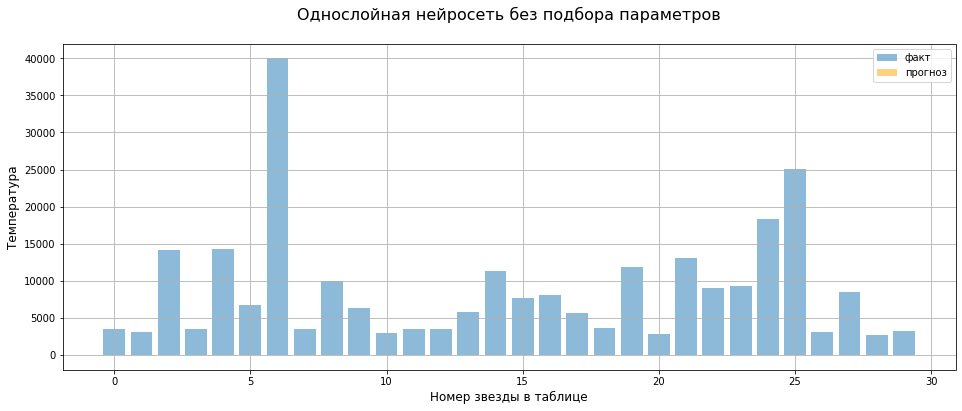

In [59]:
plot_real_pred(np.array(range(results_1b_l[1][1].shape[0])), 
               results_1b_l[1][1], results_1b_l[1][0], 
               'Однослойная нейросеть без подбора параметров')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Значение метрики RMSE показывает большое различие между предсказанными и фактическими значениями, что подтверждает выведенный график их соотношения. 
    
    
* Нейросеть, обученная на батчах, показала самое низкое значение метрики RMSE.
    
    
* Необходимо подобрать подходящие функции активации, методы регуляризации и инициализации весов, а также оптимизаторы для уменьшения значения метрики RMSE.
    
</div>

---

### Вариации параметров

Задание вариаций функций активации:

In [60]:
acts_funcs = [nn.ELU(), nn.Tanh(), nn.ReLU(), None]

acts_range = product_values([*acts_funcs], 4)

Задание вариаций методов регуляризации:

In [61]:
dropout_p_range = np.arange(0.1, 0.6, 0.1)
dropout_range = [[nn.Dropout, p] for p in dropout_p_range]

regs_range = [nn.BatchNorm1d, *dropout_range, None]

Задание вариаций инициализации весов:

In [62]:
a_b = np.arange(-2, 2.5, 0.5)

a_b_range = [[a_b[i], a_b[j]]
             for j in range(len(a_b))
             for i in range(len(a_b))
             if i < j]

mean_std_range = [[mean[0], std[0], mean[0], std[1]] 
                  for std in product_values(np.arange(0.0, 1.1, 0.5), 2)
                  for mean in product_values(np.arange(-0.5, 0.6, 0.5), 2)]

modes_nonlinearity_range = [
    ['fan_in', 'leaky_relu'], 
    ['fan_in', 'relu'], 
    ['fan_out', 'leaky_relu'],
    ['fan_out', 'relu']
]

Формирование списка вариаций инициализации весов:

In [63]:
init_w_a_b_range = [['uniform', values] 
                    for values in a_b_range]

In [64]:
init_w_mean_std_range = [[init_w, values] 
                         for values in mean_std_range
                         for init_w in ['normal']]

In [65]:
init_w_modes_nonlinearity_range = [[init_w, values]
                                   for values in modes_nonlinearity_range
                                   for init_w in ['kaiming_uniform', 'kaiming_normal']]

In [66]:
init_w_range = init_w_a_b_range
init_w_range.extend(init_w_mean_std_range)
init_w_range.extend(init_w_modes_nonlinearity_range)
init_w_range.extend([['xavier_uniform'], ['xavier_normal'], [None]])

Задание вариаций оптимизаторов:

In [67]:
optim_range = ['Adam', 'Sgd', None]

---

Задание переменной, которая будет хранить результаты сравнительного анализа:

In [68]:
results_1_l_params = pd.DataFrame()

---

**Однослойная нейросеть с подбором параметров**

Задание нейронов в слоях нейросети:

In [69]:
n_in_hidden_out_neurons = [[n_in_neurons, n_out_neurons]]

---

**Функции активации**

Обучение однослойной нейросети с подбором параметров:

In [70]:
results_1bp_l_acts = train_network_applying_params(X_train_ohe, 
                                                   y_train, 
                                                   n_in_hidden_out_neurons,
                                                   n_epochs=n_epochs, 
                                                   batch_s=batch_mini_s,
                                                   acts_range=acts_range,
                                                   check_progress_acts=True)

Activation functions progress:   0%|          | 0/256 [00:00<?, ?it/s]

Сохранение лучшего результата:

In [71]:
results_1_l_params = results_1_l_params.append(convert_to_dataframe(results_1bp_l_acts[0], 'with_acts_b'))

---

**Регуляризация весов**

Обучение однослойной нейросети с подбором параметров:

In [72]:
results_1pb_l_reg = train_network_applying_params(X_train_ohe, 
                                                  y_train, 
                                                  n_in_hidden_out_neurons,
                                                  n_epochs=n_epochs, 
                                                  batch_s=batch_mini_s,
                                                  regs_range=regs_range,
                                                  check_progress_reg=True)

Regularization methods progress:   0%|          | 0/7 [00:00<?, ?it/s]

Сохранение лучшего результата:

In [73]:
results_1_l_params = results_1_l_params.append(convert_to_dataframe(results_1pb_l_reg[0], 'with_reg_b'))

---

**Методы оптимизации**

Обучение однослойной нейросети с подбором параметров:

In [74]:
results_1pb_l_optim = train_network_applying_params(X_train_ohe, 
                                                   y_train, 
                                                   n_in_hidden_out_neurons,
                                                   n_epochs=n_epochs, 
                                                   batch_s=batch_mini_s,
                                                   optim_range=optim_range,
                                                   check_progress_optim=True)

Optimization methods progress:   0%|          | 0/3 [00:00<?, ?it/s]

Сохранение лучшего результата:

In [75]:
results_1_l_params = results_1_l_params.append(convert_to_dataframe(results_1pb_l_optim[0], 'with_optim_b'))

---

**Инициализация весов**

Обучение однослойной нейросети с подбором параметров:

In [76]:
results_1pb_l_init_w = train_network_applying_params(X_train_ohe, 
                                                     y_train, 
                                                     n_in_hidden_out_neurons,
                                                     n_epochs=n_epochs, 
                                                     batch_s=batch_mini_s,
                                                     init_w_range=init_w_range,
                                                     check_progress_init_w=True)

Init weights progress:   0%|          | 0/128 [00:00<?, ?it/s]

Сохранение лучшего результата:

In [77]:
results_1_l_params = results_1_l_params.append(convert_to_dataframe(results_1pb_l_init_w[0], 'with_init_w_b'))

---

Выведение на экран сравнительной таблицы:

In [78]:
results_1_l_params.sort_values('rmse')

,n_in_hidden_out,epoch,batch_s,optim,rmse,acts,reg,init_w
with_optim_b,20-1,650,50,SGD,1818.429321,None,None,None
with_acts_b,20-1,189,50,None,5424.929199,"ReLU, Tanh, ELU, Tanh",None,None
with_init_w_b,20-1,56,50,None,5627.499023,None,None,"{'init_w': 'uniform', 'a_b_w': [-0.5, 1.5], 'a..."
with_reg_b,20-1,476,50,None,6318.290039,None,Dropout(p=0.5),None


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Наименьшее значение метрики RMSE показала нейросеть, обученная c применением оптимизатора `optim.SGD()`.
    
* Обучение уложилось в 1000 эпох.

* Обучение происходило на батчах.
    
---
    
* Параметры, посредством которых однослойная нейросеть показала хороший результат, могут быть плохо применимы в многослойной нейронной сети.
    
</div>

Выведение на экран графика соотношения предсказаний и фактических значений:

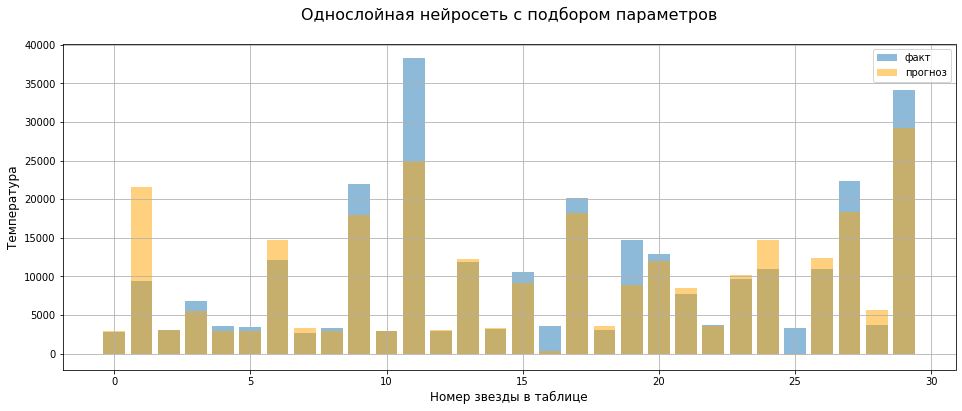

In [79]:
plot_real_pred(np.array(range(results_1pb_l_optim[1][1].shape[0])), 
               results_1pb_l_optim[1][1], results_1pb_l_optim[1][0], 
               'Однослойная нейросеть с подбором параметров')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Значение метрики RMSE показало некоторые различия между предсказанными и фактическими значениями: предсказания либо недотягивают до целевых значений, либо наоборот их переоценивают.
    
    
* Необходимо подобрать подходящее для решения поставленной задачи число скрытых слоёв нейросети.
    
    
* Дальнейшая работа будет происходить обучением на батчах с оптимизатором `optim.SGD()`. Необходимо подобрать подходящее соотношение функций активации, методовы регуляризации и инициализации весов для уменьшения значения метрики RMSE.
    
</div>

---

### Улучшение нейросети

**Многослойная нейросеть с подбором параметров**

В качестве порога метрики RMSE будет взято значение 4500.

Поскольку однослойная нейросеть показала наименьшее значение RMSE при использовании оптимизатора `optim.SGD()` на батчах, необходимо провести обучение многослойной нейросети по подбору оптимизатора для сравнения поведения с однослойной нейросетью. Полученная в результате модель станет основой для её улучшения посредством подбора функций активации, методов регуляризации и инициализации весов.

Задание переменной, которая будет хранить результаты сравнительного анализа:

In [80]:
results_n_l_params = pd.DataFrame()

---

Задание вариаций нейронов в слоях нейросети:

In [81]:
neurons_range = np.array([n_in_neurons // 2, n_in_neurons // 2 // 2, n_in_neurons // 2 // 2 // 2])

In [82]:
n_in_hidden_out_neurons_range = product_values(neurons_range, 3)
n_in_hidden_out_neurons_range.extend(product_values(neurons_range[:-1], 2))
n_in_hidden_out_neurons_range.extend(product_values(neurons_range[1:], 2))
n_in_hidden_out_neurons_range.extend(product_values(neurons_range[[0, 2]], 2))
n_in_hidden_out_neurons_range.extend([[n_in_neurons] * 3])
n_in_hidden_out_neurons_range.extend([[n_in_neurons] * 2])

In [83]:
n_in_hidden_out_neurons_range = [[n_in_neurons, *n_in_hidden_out, n_out_neurons]
                                 for n_in_hidden_out in n_in_hidden_out_neurons_range]

---

**Оптимизаторы и количество слоёв**

Обучение многослойной нейросети с подбором параметров:

In [84]:
results_np_l_imp = train_network_applying_params(X_train_ohe, 
                                                 y_train, 
                                                 n_in_hidden_out_neurons_range=n_in_hidden_out_neurons_range,
                                                 n_epochs=n_epochs, 
                                                 batch_s=batch_mini_s,
                                                 optim_range=optim_range,
                                                 rmse_threshold=np.inf,
                                                 check_progress_in_hidden_out=True,
                                                 check_progress_optim=True)

Optimization methods progress:   0%|          | 0/3 [00:00<?, ?it/s]

Input-Hidden-Output neurons progress:   0%|          | 0/41 [00:00<?, ?it/s]

Выведение на экран лучшего результата:

In [85]:
convert_to_dataframe(results_np_l_imp[0])

,n_in_hidden_out,epoch,batch_s,optim,rmse,acts,reg,init_w
results,20-10-5-1,333,50,Adam,1293.946533,None,None,None


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">    
    
* Оптимизатор, уменьшающий значение метрики RMSE в многослойной нейросети, отличается от оптимизатора, выявленного при обучении однослойной нейросети.
    
    
* Следующий шаг уменьшения значения метрики RMSE заключается в подборе функций активации.
    
</div>

Задание значений оптимизатора и количества входных, скрытых и выходных нейронов:

In [86]:
optim = [results_np_l_imp[0]['optim']]

n_in_hidden_out_neurons = [[int(n) 
                            for n in results_np_l_imp[0]['n_in_hidden_out'].split('-')]]

Обучение многослойной нейросети с подбором параметров:

In [87]:
results_np_l_imp = train_network_applying_params(X_train_ohe, 
                                                 y_train, 
                                                 n_in_hidden_out_neurons_range=n_in_hidden_out_neurons,
                                                 n_epochs=n_epochs, 
                                                 batch_s=batch_mini_s,
                                                 acts_range=acts_range,
                                                 optim_range=optim,
                                                 rmse_threshold=4500.,
                                                 check_progress_acts=True)

Activation functions progress:   0%|          | 0/256 [00:00<?, ?it/s]

Выведение на экран лучшего результата:

In [88]:
convert_to_dataframe(results_np_l_imp[0])

,n_in_hidden_out,epoch,batch_s,optim,rmse,acts,reg,init_w
results,20-10-5-1,694,50,Adam,963.119568,"Tanh, ELU, ELU, ReLU",None,None


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Дальнейшее уменьшение значения метрики RMSE может привести к переобучению.
    
</div>

Сохранение значений функций активации на слоях:

In [89]:
acts = [[]]

for act in results_np_l_imp[0]['acts'].split(', '):
    for func in acts_funcs:
        if act in str(func):
            acts[0].append(func)

Выведение на экран графика соотношения предсказаний и фактических значений:

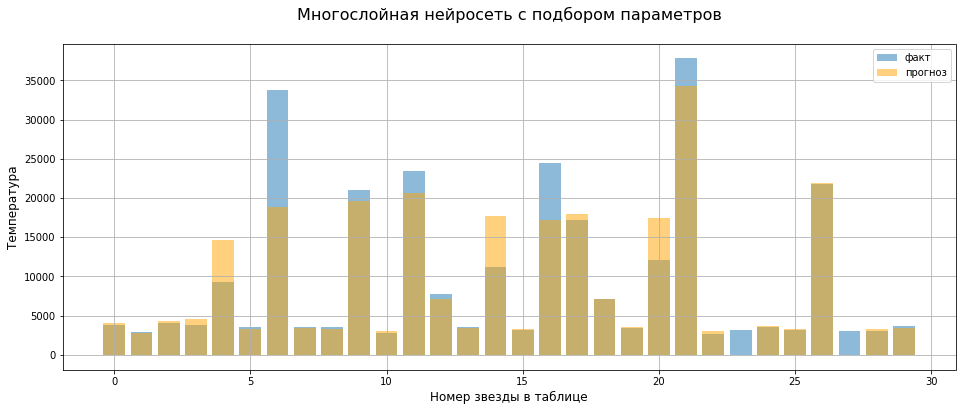

In [90]:
plot_real_pred(np.array(range(results_np_l_imp[1][1].shape[0])), 
               results_np_l_imp[1][1], results_np_l_imp[1][0], 
               'Многослойная нейросеть с подбором параметров')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Наблюдаются некоторые различия между предсказанными и фактическими значениями: предсказания у некоторых номеров звёзд недотягивают до целевых значений.
    
</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

### Тестирование нейросети

Объявление нейросети:

In [91]:
net_test = get_net(*n_in_hidden_out_neurons, *acts)

Обучение нейросети: 

In [92]:
results_test = train_net(
    net_test, 
    *n_in_hidden_out_neurons,
    X_test_ohe, 
    y_test, 
    n_epochs=n_epochs, 
    batch_s=batch_mini_s,
    optim=get_optim(net_test, *optim)
)

Epoch 0 | RMSE 19000.548828125
Epoch 100 | RMSE 16718.7578125
Epoch 200 | RMSE 8972.3798828125
Epoch 300 | RMSE 7972.9326171875
Epoch 400 | RMSE 4540.23046875
Epoch 500 | RMSE 1914.6158447265625
Epoch 600 | RMSE 1586.60986328125
Epoch 700 | RMSE 3365.235107421875
Epoch 800 | RMSE 6972.95654296875
Epoch 900 | RMSE 3768.3759765625
Epoch 999 | RMSE 2699.00341796875


Выведение на экран лучшего результата:

In [93]:
convert_to_dataframe(results_test[0])

,n_in_hidden_out,epoch,batch_s,optim,rmse
results,20-10-5-1,558,50,Adam,304.754791


Выведение на экран графика соотношения предсказаний и фактических значений:

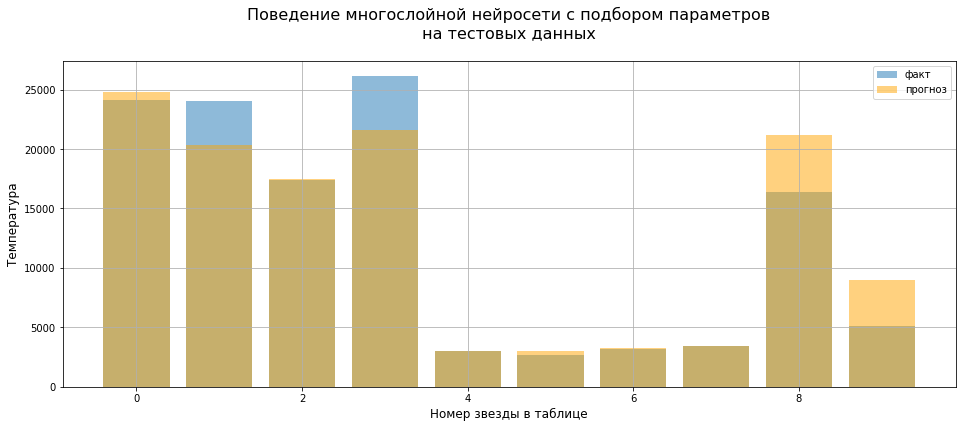

In [94]:
plot_real_pred(np.array(range(results_test[1][1].shape[0])), 
               results_test[1][1], results_test[1][0], 
               'Поведение многослойной нейросети с подбором параметров\nна тестовых данных')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Наблюдается хорошая предсказательная способность обученной нейросети.
    
</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Выводы

Были проведены анализ и предподготовка исходного набора данных для приведения значений к надлежащему виду перед построением нейронной сети, решающей поставленную задачу.

В ходе выбора подхода к построению нейросети были изучены базовая и улучшенная нейросети. Изучение поведения данных на базовой нейросети помогло установить необходимый подход для улучшения модели.

Исследование показало, что применение нейросети решает задачу определения температуры на поверхности звёзд. При этом качество предсказания было улучшено за счёт:

* увеличения числа слоёв
* подбора оптимизатора
* тестирования на вариациях размерностей скрытых слоёв
* подбора функций активации для входного, скрытых чётных, скрытых нечётных и выходных слоёв

Нейросеть была протестирована на тестовой выборке, результат вычисленния значения метрики RMSE на которой также удовлетворил установленному порогу её значения.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Прогнозирование-температуры-звезды" data-toc-modified-id="Прогнозирование-температуры-звезды" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>